In [2]:
import pandas as pd
import matplotlib.pyplot as plt

DWF Version:  b'3.24.4'
Number of devices found: 15
Detected device: Analog Discovery 3
Demo device opened successfully!
Generating sine wave...
Starting oscilloscope
Recording done


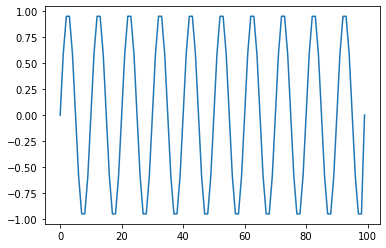

In [ ]:
# Import libraries
from ctypes import *
from dwfconstants import *
from sys import platform, path
import os
import math
import time
import matplotlib.pyplot as plt
import sys
import numpy

#declare ctype variables
hdwf = c_int()
sts = c_byte()
cAvailable = c_int()
cLost = c_int()
cCorrupted = c_int()
fLost = 0
fCorrupted = 0


#Import dwfconstants.py
dwf = cdll.dwf
constants_path = "C:/Program Files (x86)/Digilent/WaveFormsSDK/samples/python"
path.append(constants_path)
from dwfconstants import *

#declare ctype variables
hdwf = c_int()
sts = c_byte()
rgdSamples = (c_double*4000)()

#Fetching DWF version
version = create_string_buffer(16)
dwf.FDwfGetVersion(version)
print("DWF Version: ",version.value)

#Enumerate devices and print count
filter_flags = c_int(enumfilterType.value | enumfilterDemo.value)
device_count = c_int()
dwf.FDwfEnum(filter_flags, byref(device_count))
print(f"Number of devices found: {device_count.value}")

#Get device name
name_buf = create_string_buffer(64)
dwf.FDwfEnumDeviceName(c_int(0), name_buf)
print(f"Detected device: {name_buf.value.decode()}")

#Connect demo device
hdwf = c_int()
dwf.FDwfDeviceOpen(c_int(0), byref(hdwf))
if hdwf.value == 0:
    raise RuntimeError("Demo device not available.")
print("Demo device opened successfully!")

dwf.FDwfDeviceAutoConfigureSet(hdwf, c_int(0)) # 0 = the device will only be configured when FDwf###Configure is called


# Waveform generation
print("Generating sine wave...")
dwf.FDwfAnalogOutNodeEnableSet(hdwf, c_int(0), AnalogOutNodeCarrier, c_int(1))
dwf.FDwfAnalogOutNodeFunctionSet(hdwf, c_int(0), AnalogOutNodeCarrier, funcSine)
dwf.FDwfAnalogOutNodeFrequencySet(hdwf, c_int(0), AnalogOutNodeCarrier, c_double(10e03))
dwf.FDwfAnalogOutNodeAmplitudeSet(hdwf, c_int(0), AnalogOutNodeCarrier, c_double(1))
dwf.FDwfAnalogOutConfigure(hdwf, c_int(0), c_int(1))

# Oscilloscope
sampling_frequency = 100e03
buffer_size = 100
amplitude_range = 10
offset =0
sts = c_byte()
rgdSamples = (c_double*c_int(buffer_size).value)()

dwf.FDwfAnalogInChannelEnableSet(hdwf, c_int(0), c_bool(True))
dwf.FDwfAnalogInChannelOffsetSet(hdwf, c_int(0), c_double(offset))
dwf.FDwfAnalogInChannelRangeSet(hdwf, c_int(0), c_double(amplitude_range))
dwf.FDwfAnalogInAcquisitionModeSet(hdwf, acqmodeRecord)
dwf.FDwfAnalogInRecordLengthSet(hdwf, c_double(buffer_size/sampling_frequency))
dwf.FDwfAnalogInBufferSizeSet(hdwf, c_int(buffer_size))
dwf.FDwfAnalogInFrequencySet(hdwf, c_double(sampling_frequency))
dwf.FDwfAnalogInChannelFilterSet(hdwf, c_int(-1), filterDecimate)

time.sleep(2)

print("Starting oscilloscope")
dwf.FDwfAnalogInConfigure(hdwf, c_int(1), c_int(1))

cSamples = 0

while cSamples < buffer_size:
    dwf.FDwfAnalogInStatus(hdwf, c_int(1), byref(sts))
    if cSamples == 0 and (sts == DwfStateConfig or sts == DwfStatePrefill or sts == DwfStateArmed) :
        # Acquisition not yet started.
        continue

    dwf.FDwfAnalogInStatusRecord(hdwf, byref(cAvailable), byref(cLost), byref(cCorrupted))
    
    cSamples += cLost.value

    if cLost.value :
        fLost = 1
    if cCorrupted.value :
        fCorrupted = 1

    if cAvailable.value==0 :
        continue

    if cSamples+cAvailable.value > buffer_size :
        cAvailable = c_int(buffer_size-cSamples)
    
    dwf.FDwfAnalogInStatusData(hdwf, c_int(0), byref(rgdSamples, sizeof(c_double)*cSamples), cAvailable) # get channel 1 data
    #dwf.FDwfAnalogInStatusData(hdwf, c_int(1), byref(rgdSamples, sizeof(c_double)*cSamples), cAvailable) # get channel 2 data
    cSamples += cAvailable.value

dwf.FDwfAnalogOutReset(hdwf, c_int(0))
dwf.FDwfDeviceCloseAll()

print("Recording done")
if fLost:
    print("Samples were lost! Reduce frequency")
if fCorrupted:
    print("Samples could be corrupted! Reduce frequency")

f = open("{}+record.csv", "w")
for v in rgdSamples:
    f.write("%s\n" % v)
f.close()
  
#plt.subplot(2,1,1)

plt.plot(numpy.fromiter(rgdSamples, dtype = float))
#plt.subplot(2,1,2)
#plt.specgram(numpy.fromiter(rgdSamples, dtype = float), Fs=sampling_frequency)
#plt.show()
#plt.legend()